In [1]:

# ====================================================
# 🧩 Unified Data Preprocessing Script (CPU Version)
# ====================================================
# Author: Swapneel Purohit
# Description: Combines multiple chest imaging datasets into a unified format.
# Works with: chest_xray_pneumonia, covid19_radiography, sarscov2_ctscan
# ====================================================
# ================================================================
# 🧩 PHASE 1 — Unified Data Preprocessing (All Datasets)
# ================================================================
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import pickle

# ------------------------------------------------
# 🎨 Helper for colorful printing
# ------------------------------------------------
def banner(text, color="\033[96m"):
    print(f"\n{color}{'='*70}\n{text}\n{'='*70}\033[0m")

# ------------------------------------------------
# ⚙️ Configurations
# ------------------------------------------------
DATA_DIR = "../data"
PROCESSED_DIR = "../data/intermediate/"
IMG_SIZE = (224, 224)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# ------------------------------------------------
# 📦 Utility function to load images safely
# ------------------------------------------------
def load_images_from_folder(folder, label_name, limit=None):
    images, labels = [], []
    files = sorted(os.listdir(folder))[:limit] if limit else sorted(os.listdir(folder))
    for f in tqdm(files, desc=f"🖼️ {label_name}"):
        path = os.path.join(folder, f)
        try:
            img = Image.open(path).convert("RGB").resize(IMG_SIZE)
            images.append(np.array(img))
            labels.append(label_name)
        except Exception:
            continue
    return images, labels

# ------------------------------------------------
# 🚀 Load datasets
# ------------------------------------------------
all_images, all_labels = [], []

# ---- Chest X-ray Pneumonia ----
banner("🚀 Loading Chest X-ray Pneumonia Dataset", "\033[95m")
base = os.path.join(DATA_DIR, "chest_xray_pneumonia")
for phase in ["train", "val", "test"]:
    for label in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(base, phase, label)
        if os.path.exists(path):
            imgs, lbls = load_images_from_folder(path, label)
            all_images.extend(imgs)
            all_labels.extend(lbls)
        else:
            print(f"⚠️ Missing folder: {path}")

# ---- COVID19 Radiography ----
banner("🚀 Loading COVID-19 Radiography Dataset", "\033[94m")
base = os.path.join(DATA_DIR, "covid19_radiography")
for label in ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]:
    path = os.path.join(base, label, "images")
    if os.path.exists(path):
        imgs, lbls = load_images_from_folder(path, label)
        all_images.extend(imgs)
        all_labels.extend(lbls)
    else:
        print(f"⚠️ Missing folder: {path}")

# ---- SARS-CoV-2 CT Scan ----
banner("🚀 Loading SARS-CoV-2 CT Scan Dataset", "\033[92m")
base = os.path.join(DATA_DIR, "sarscov2_ctscan/archive")
for label in ["COVID", "non-COVID"]:
    path = os.path.join(base, label)
    if os.path.exists(path):
        imgs, lbls = load_images_from_folder(path, label)
        all_images.extend(imgs)
        all_labels.extend(lbls)
    else:
        print(f"⚠️ Missing folder: {path}")

# ---- RSNA Pneumonia ---- (limited to 500 images for 16GB RAM)
banner("🚀 Loading RSNA Pneumonia Detection Challenge", "\033[93m")
base = os.path.join(DATA_DIR, "rsna_pneumonia/rsna-pneumonia-detection-challenge")
for sub in ["stage_2_train_images", "stage_2_test_images"]:
    path = os.path.join(base, sub)
    if os.path.exists(path):
        imgs, lbls = load_images_from_folder(path, "RSNA_Unlabeled", limit=500)
        all_images.extend(imgs)
        all_labels.extend(lbls)
    else:
        print(f"⚠️ Missing folder: {path}")

# ------------------------------------------------
# 💾 Save intermediate data
# ------------------------------------------------
banner("💾 Saving Intermediate Data", "\033[92m")
X = np.array(all_images)
y = np.array(all_labels)

with open(os.path.join(PROCESSED_DIR, "phase1_preprocessed.pkl"), "wb") as f:
    pickle.dump({"X": X, "y": y}, f)

print(f"✅ Saved: {X.shape[0]} images, {len(set(y))} classes to phase1_preprocessed.pkl")



🚀 Loading Chest X-ray Pneumonia Dataset
⚠️ Missing folder: ../data/chest_xray_pneumonia/train/NORMAL
⚠️ Missing folder: ../data/chest_xray_pneumonia/train/PNEUMONIA
⚠️ Missing folder: ../data/chest_xray_pneumonia/val/NORMAL
⚠️ Missing folder: ../data/chest_xray_pneumonia/val/PNEUMONIA
⚠️ Missing folder: ../data/chest_xray_pneumonia/test/NORMAL
⚠️ Missing folder: ../data/chest_xray_pneumonia/test/PNEUMONIA

🚀 Loading COVID-19 Radiography Dataset


🖼️ Viral Pneumonia: 100%|██████████| 1345/1345 [00:02<00:00, 547.49it/s]



🚀 Loading SARS-CoV-2 CT Scan Dataset


🖼️ non-COVID: 100%|██████████| 1229/1229 [00:03<00:00, 403.25it/s]



🚀 Loading RSNA Pneumonia Detection Challenge


🖼️ RSNA_Unlabeled: 100%|██████████| 500/500 [00:00<00:00, 4504.39it/s]



💾 Saving Intermediate Data
✅ Saved: 23646 images, 5 classes to phase1_preprocessed.pkl


In [3]:
# ================================================================
# 🧩 PHASE 2 — Chunked Splitting & Saving
# ================================================================
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from termcolor import colored

# ------------------------------------------------
# 🎨 Visual Banner
# ------------------------------------------------
def banner(text, color="cyan"):
    print(colored("="*70, color))
    print(colored(text, color, attrs=["bold"]))
    print(colored("="*70, color))

# ------------------------------------------------
# ⚙️ Configurations
# ------------------------------------------------
DATA_ROOT = "../data"   # ✅ Define DATA_ROOT here
INTERMEDIATE_PATH = os.path.join(DATA_ROOT, "intermediate", "phase1_preprocessed.pkl")
PROCESSED_DIR = os.path.join(DATA_ROOT, "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

banner("🚀 PHASE 2 — Chunked Splitting & Saving", "yellow")

# ------------------------------------------------
# 📂 Load Phase 1 data
# ------------------------------------------------
print(colored(f"📦 Loading Phase 1 Data from: {INTERMEDIATE_PATH}", "blue"))
with open(INTERMEDIATE_PATH, "rb") as f:
    data = pickle.load(f)

X = data["X"]
y = data["y"]
print(colored(f"✅ Loaded {len(X)} images, Shape: {X.shape}", "green"))

# ------------------------------------------------
# 🔄 Encode labels to integers (if needed)
# ------------------------------------------------
unique_labels = sorted(set(y))
label_to_int = {label: i for i, label in enumerate(unique_labels)}
y_encoded = np.array([label_to_int[label] for label in y])

print(colored(f"🏷️ Labels encoded: {label_to_int}", "cyan"))

# ------------------------------------------------
# 🧠 Train/Val/Test Split (80/10/10)
# ------------------------------------------------
banner("📊 Splitting Data into Train / Validation / Test", "magenta")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(colored(f"✅ Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}", "green"))

# ------------------------------------------------
# 💾 Chunked Saving to .npy (Memory-Safe)
# ------------------------------------------------
banner("💾 Saving Chunked NumPy Arrays", "yellow")

def save_in_chunks(X, y, name, chunk_size=2000):
    total = len(X)
    chunks = (total // chunk_size) + 1
    print(colored(f"💽 Saving {name} set in {chunks} chunks...", "blue"))
    for i in tqdm(range(chunks), desc=f"Saving {name}"):
        start, end = i * chunk_size, min((i + 1) * chunk_size, total)
        np.save(os.path.join(PROCESSED_DIR, f"{name}_X_part{i}.npy"), X[start:end])
        np.save(os.path.join(PROCESSED_DIR, f"{name}_y_part{i}.npy"), y[start:end])

save_in_chunks(X_train, y_train, "train", chunk_size=1500)
save_in_chunks(X_val, y_val, "val", chunk_size=1500)
save_in_chunks(X_test, y_test, "test", chunk_size=1500)

print(colored("\n✅ All splits saved successfully to /data/processed/", "green", attrs=["bold"]))

# ------------------------------------------------
# 📊 Summary Report
# ------------------------------------------------
banner("📋 FINAL SUMMARY", "cyan")
print(colored(f"🧠 Total Images: {len(X)}", "yellow"))
print(colored(f"🏷️ Classes: {unique_labels}", "yellow"))
print(colored(f"💾 Saved to: {PROCESSED_DIR}", "green"))
print(colored("🎯 Phase 2 complete — Ready for visualization!", "magenta", attrs=["bold"]))


🚀 PHASE 2 — Chunked Splitting & Saving
📦 Loading Phase 1 Data from: ../data/intermediate/phase1_preprocessed.pkl
✅ Loaded 23646 images, Shape: (23646, 224, 224, 3)
🏷️ Labels encoded: {np.str_('COVID'): 0, np.str_('Lung_Opacity'): 1, np.str_('Normal'): 2, np.str_('Viral Pneumonia'): 3, np.str_('non-COVID'): 4}
📊 Splitting Data into Train / Validation / Test
✅ Train: 18916 | Val: 2365 | Test: 2365
💾 Saving Chunked NumPy Arrays
💽 Saving train set in 13 chunks...


Saving train: 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


💽 Saving val set in 2 chunks...


Saving val: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]


💽 Saving test set in 2 chunks...


Saving test: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


✅ All splits saved successfully to /data/processed/
📋 FINAL SUMMARY
🧠 Total Images: 23646
🏷️ Classes: [np.str_('COVID'), np.str_('Lung_Opacity'), np.str_('Normal'), np.str_('Viral Pneumonia'), np.str_('non-COVID')]
💾 Saved to: ../data/processed
🎯 Phase 2 complete — Ready for visualization!


🎨 PHASE 3 — Visualization & Sanity Check
📦 Loading train_X_part0.npy
📦 Loading train_X_part1.npy
📦 Loading train_X_part10.npy
📦 Loading train_X_part11.npy
📦 Loading train_X_part12.npy
📦 Loading train_X_part2.npy
📦 Loading train_X_part3.npy
📦 Loading train_X_part4.npy
📦 Loading train_X_part5.npy
📦 Loading train_X_part6.npy
📦 Loading train_X_part7.npy
📦 Loading train_X_part8.npy
📦 Loading train_X_part9.npy
✅ train: X=(18916, 224, 224, 3), y=(18916,)
📦 Loading val_X_part0.npy
📦 Loading val_X_part1.npy
✅ val: X=(2365, 224, 224, 3), y=(2365,)
📦 Loading test_X_part0.npy
📦 Loading test_X_part1.npy
✅ test: X=(2365, 224, 224, 3), y=(2365,)
📊 LABEL DISTRIBUTION
📁 Train — Total: 18916
   4: 983 (5.20%)
   2: 8153 (43.10%)
   1: 4810 (25.43%)
   0: 3894 (20.59%)
   3: 1076 (5.69%)
📁 Validation — Total: 2365
   0: 487 (20.59%)
   2: 1019 (43.09%)
   1: 601 (25.41%)
   3: 135 (5.71%)
   4: 123 (5.20%)
📁 Test — Total: 2365
   4: 123 (5.20%)
   2: 1020 (43.13%)
   1: 601 (25.41%)
   0: 487 (20.59%)
  

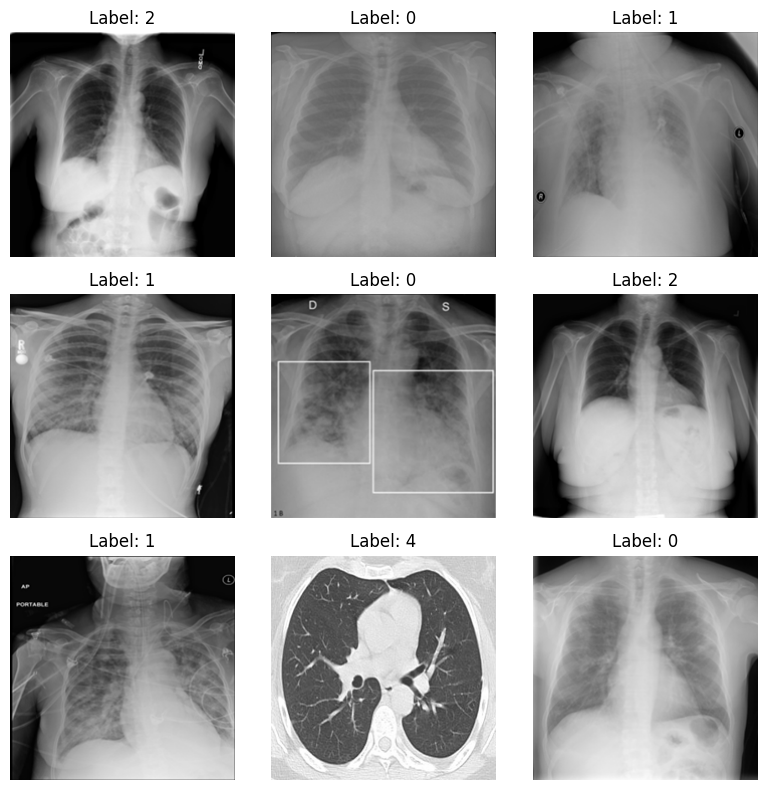

✅ Phase 3 completed successfully!


In [7]:
# ================================================================
# 🎨 PHASE 3 — Visualization & Sanity Check (for Chunked Files)
# ================================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored
from glob import glob
from collections import Counter
import random

# ------------------------------------------------
# ⚙️ CONFIG
# ------------------------------------------------
DATA_ROOT = "../data"
PROCESSED_DIR = os.path.join(DATA_ROOT, "processed")

def banner(text, color="cyan"):
    print(colored("="*70, color))
    print(colored(text, color, attrs=["bold"]))
    print(colored("="*70, color))

banner("🎨 PHASE 3 — Visualization & Sanity Check", "magenta")

# ------------------------------------------------
# 📂 Load Chunked Arrays
# ------------------------------------------------
def load_chunked_arrays(prefix):
    x_paths = sorted(glob(os.path.join(PROCESSED_DIR, f"{prefix}_X_part*.npy")))
    y_paths = sorted(glob(os.path.join(PROCESSED_DIR, f"{prefix}_y_part*.npy")))

    if not x_paths:
        print(colored(f"⚠️ No chunked files found for {prefix}. Run Phase 2 first.", "red"))
        return None, None

    X_parts, y_parts = [], []
    for xp, yp in zip(x_paths, y_paths):
        print(colored(f"📦 Loading {os.path.basename(xp)}", "yellow"))
        X_parts.append(np.load(xp))
        y_parts.append(np.load(yp))
    X = np.concatenate(X_parts)
    y = np.concatenate(y_parts)
    print(colored(f"✅ {prefix}: X={X.shape}, y={y.shape}", "green"))
    return X, y

# ------------------------------------------------
# 🧠 Load sets
# ------------------------------------------------
X_train, y_train = load_chunked_arrays("train")
X_val, y_val = load_chunked_arrays("val")
X_test, y_test = load_chunked_arrays("test")

# ------------------------------------------------
# 📊 Summary
# ------------------------------------------------
banner("📊 LABEL DISTRIBUTION", "cyan")

def summarize_labels(y, name):
    counts = Counter(y)
    total = len(y)
    print(colored(f"📁 {name} — Total: {total}", "blue"))
    for k, v in counts.items():
        print(f"   {k}: {v} ({v/total*100:.2f}%)")

summarize_labels(y_train, "Train")
summarize_labels(y_val, "Validation")
summarize_labels(y_test, "Test")

# ------------------------------------------------
# 🖼️ Random samples
# ------------------------------------------------
banner("🖼️ RANDOM SAMPLE VISUALIZATION", "magenta")

idxs = random.sample(range(len(X_train)), min(9, len(X_train)))
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax, i in zip(axes.ravel(), idxs):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

print(colored("✅ Phase 3 completed successfully!", "green", attrs=["bold"]))
